# Predict survival

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import numpy as np

np.random.seed(42)

In [2]:
# Load the dataset into a pandas DataFrame
data = pd.read_excel('./d1.xlsx')
data = data[data["safety"]==1] #select safety analysis
data = data.drop('PatientCode',axis=1) #drop one row with Nan value
data = data[~data.isin([-99]).any(axis=1)] #drop any rows with -99 value
# For now, remove all rows with Nan values
# remove rows with NaN values, it's actually only one row
data = data.dropna()

print(len(data))

267


In [3]:
# split TR, TS
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
# x, y split
# train
y_train = train["os event"]
x_train = train.drop(['os event'], axis=1)

# test
y_test = test["os event"]
x_test = test.drop(['os event'], axis=1)

# RFE (feature selection)

In [5]:
min_features_to_select = 1
# RFE
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    step=1, # number of feature to eliminate per iteration
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select
)
# fit
rfecv.fit(x_train, y_train)

# print optimal number of feature selected
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 10


In [6]:
# return the selected columns
x_train.columns[(rfecv.get_support())]

Index(['age @random', 'dos', '1stpfs event', 'dpfs', 'outcome of surgery',
       'RTK_RAS', 'WNT', 'HIPPO', 'CELL_CYCLE', 'TP53'],
      dtype='object')

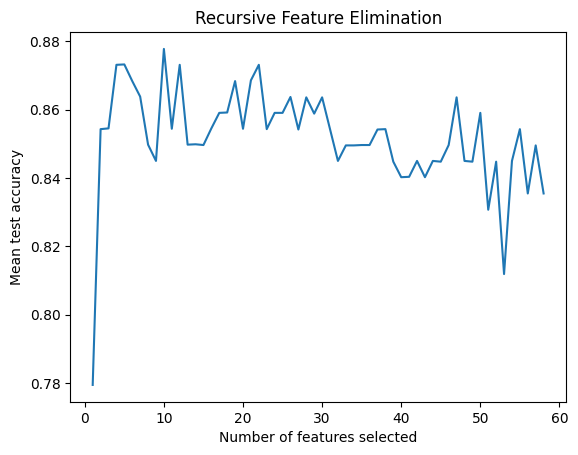

In [7]:
# Plot accuracy and number of features 

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    #yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [17]:
max(rfecv.cv_results_["mean_test_score"])

0.8777408637873755

In [8]:
rfecv.ranking_ # vote rank per feature 

array([21, 19, 47,  1, 17, 28, 16, 24, 23, 12,  2, 25, 20, 26, 13, 15, 22,
       30, 37, 43, 40, 14,  1,  1,  1, 10, 18, 36, 49, 35, 42, 39, 31, 27,
       48, 29, 38, 46, 45, 44, 41,  8, 33,  5,  3,  6,  1,  9,  1, 34,  7,
        1,  1,  1, 32,  4, 11,  1])

In [9]:
rfecv.support_ # selected features

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True,  True,  True,
       False, False, False,  True])

# Random forest prediction with selected data

In [10]:
# predict
y_pred = rfecv.predict(x_test)

# Accuracy of RF on Test

In [11]:
# compute accuracy
accuracy_score(y_test, y_pred)

0.8703703703703703

In [12]:
# save model

# Select data with relevant features

In [13]:
# data with only the selected features, converted automatically into narray
selected_x_train = rfecv.transform(x_train)
selected_x_test = rfecv.transform(x_test)

# KNN on selected data

In [14]:
# Grid search for KNN

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
 
# Creating the hyperparameter grid
param_grid = {'n_neighbors': [3,5,10,15,20],
              'weights': ['uniform','distance'],
              'metric': ['euclidean','minkowski','cosine']}

 
# Instantiating knn classifier
knn = KNeighborsClassifier()
 
# Instantiating the GridSearchCV object
knn_cv = GridSearchCV(knn, param_grid, cv = 5, refit=True)
 
knn_cv.fit(selected_x_train, y_train)
 
# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score on validation is {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
Best score on validation is 0.8777408637873754


# Model assesment

In [15]:
from sklearn.metrics import classification_report

# prediction
grid_predictions = knn_cv.predict(selected_x_test) 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.94      0.85      0.89        39

    accuracy                           0.85        54
   macro avg       0.81      0.86      0.83        54
weighted avg       0.87      0.85      0.86        54



In [18]:
#pickle.dump(knn_cv, open('KNN.pkl', 'wb'))
#pickle.dump(rfecv, open('rfecv_RF.pkl', 'wb'))